##  Toronto Neighborhoods Segmenting and Clustering  

#### *Author: Mohammad Sayeb*

#### Let's import the relevant modules

In [1]:
import numpy as np #for dealing with multidimensional arrays and matrices
import pandas as pd #pandas data frame from efficient dataframe manipulation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
import geocoder # convert an address into latitude and longitude values
!pip3 install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests #requesting information from webpages 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import plotly #visualization tool

# Matplotlib and associated plotting modules
import matplotlib 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

#tools for scrapping website for data
import bs4 #beautiful soup library for website scraping 
from bs4 import BeautifulSoup #scraping tool
import lxml #needed to convert html bs4 object to data frame


Defaulting to user installation because normal site-packages is not writeable


## Section 1

We scrape table data from the wiki page and assign it to a DataFrame table

In [2]:
URL='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
table = soup.find_all('table')

In [4]:
df = pd.read_html(str(table))[0]

In [5]:
df.shape

(180, 3)

Ignore the rows that don't have an assigned borough

In [6]:
df = df[df['Borough']!='Not assigned']
print (df.shape)
df.head()

(103, 3)


,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now we would like to put the neighborhoods that belong to the same postal code in the same row separated by commas. The fist step here is to see if there are any duplicated values for the Postal Codes.

In [7]:
duplicate_boolean = df.duplicated(subset=None, keep='first')
duplicate_boolean[duplicate_boolean ==True]

Series([], dtype: bool)

We see that there are no duplicated postal code values we don't need to worry about combining the Neighbourhoods that belong to the same Postal Code into one row separated by commas

If a cell has a borough but a Not assigned neighbourhood, then the neighborhood will be the same as the borough

In [8]:
df[df['Neighbourhood']=='Not assigned']

,Postal Code,Borough,Neighbourhood


There are no rows with a Not assinged neighbourhood

In [9]:
print ('the data frame has {} rows and {} columns'.format(df.shape[0],df.shape[1]))
df.shape

the data frame has 103 rows and 3 columns


(103, 3)

## Section 2

Now let's try to get the lattitude and Longitude for each neightbourhood

In [10]:
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


We use geocoder to get the longitude and latitude for each postal code. 

In [11]:
latitude=[]
longitude=[]
for postal_code in df['Postal Code']:

    # initialize your variable to None
    lat_lng_coords = None
#     print ('{}, Toronto, Ontario'.format(postal_code))
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

    latitude.append( lat_lng_coords[0])
    longitude.append( lat_lng_coords[1])

In [12]:
df['latitude'] = latitude
df['longitude'] = longitude
df.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
2,M3A,North York,Parkwoods,43.75245,-79.32991
3,M4A,North York,Victoria Village,43.73057,-79.31306
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


In [13]:
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)

In [14]:
df.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


In [15]:
df[df['Neighbourhood']=='Roselawn']

,Postal Code,Borough,Neighbourhood,latitude,longitude
62,M5N,Central Toronto,Roselawn,43.71208,-79.41848


## Section 3

get latitude and longitude of Toronto

In [16]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto  are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto  are 43.6534817, -79.3839347.


In [17]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(tiles = 'StamenTerrain', location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Toronto. So let's slice the original dataframe and create a new dataframe of the Toronto data.

In [18]:
df_toronto = df[df['Borough'].str.contains('oronto')]

In [19]:
df_toronto.reset_index(drop = True, inplace=True)
df_toronto.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587
4,M4E,East Toronto,The Beaches,43.67709,-79.29547


Here we are visualizing the new neightbourhoods

In [20]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(tiles = 'StamenTerrain',location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto['latitude'], df_toronto['longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Next, we are going to utilize the Foursquare API to explore the neighborhoods and segment them.

In [21]:
CLIENT_ID = 'ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5' # your Foursquare ID
CLIENT_SECRET = 'OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5
CLIENT_SECRET:OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW


#### Let's explore the first neighbourhood in our data frame

In [22]:
neighborhood_latitude = df_toronto.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto.loc[0, 'longitude'] # neighborhood longitude value
neighborhood_name = df_toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.65512000000007, -79.36263999999994.


#### Let's look at the top 100 venues around Regend Park, Harbourfront neighbourhood within  a radius of 500 meters

In [23]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(\
CLIENT_ID,
CLIENT_SECRET,
VERSION,
neighborhood_latitude,
neighborhood_longitude,
radius,
LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5&client_secret=OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW&v=20180605&ll=43.65512000000007,-79.36263999999994&radius=500&limit=100'

In [24]:
results = requests.get(url).json()  #gives result as a dictionary

#### Let's see what the result object is made of

In [25]:
print (results.keys())
print ()
print ('keys for meta are:',results['meta'].keys())
print ()
print ('keys for response are:',results['response'].keys())
print ()
print ("result['response']['groups'] are ", results['response']['groups'][0].keys())

dict_keys(['meta', 'response'])

keys for meta are: dict_keys(['code', 'requestId'])

keys for response are: dict_keys(['suggestedFilters', 'headerLocation', 'headerFullLocation', 'headerLocationGranularity', 'totalResults', 'suggestedBounds', 'groups'])

result['response']['groups'] are  dict_keys(['type', 'name', 'items'])


#### Let's define a function that gets the catagory of a venue. We will use this funciton clean up and convert our data into a dataframe format 

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    #try:
        #categories_list = row['categories'] # we don't really need this line since we only have the venue.categories as the column title
    #except:
    categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # tranform JSON file into a pandas dataframe

/Users/sayebms1/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id,venue.location.neighborhood
0,e-0-54ea41ad498e9a11e9e13308-0,0,"[{'summary': 'This spot is popular', 'type': '...",54ea41ad498e9a11e9e13308,Roselle Desserts,362 King St E,Trinity St,43.653447,-79.362017,"[{'label': 'display', 'lat': 43.65344672305267...",192,M5A 1K9,CA,Toronto,ON,Canada,"[362 King St E (Trinity St), Toronto ON M5A 1K...","[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",0,[],NaN,NaN
1,e-0-53b8466a498e83df908c3f21-1,0,"[{'summary': 'This spot is popular', 'type': '...",53b8466a498e83df908c3f21,Tandem Coffee,368 King St E,at Trinity St,43.653559,-79.361809,"[{'label': 'display', 'lat': 43.65355870959944...",186,NaN,CA,Toronto,ON,Canada,"[368 King St E (at Trinity St), Toronto ON, Ca...","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN,NaN
2,e-0-4af59046f964a520e0f921e3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4af59046f964a520e0f921e3,Figs Breakfast & Lunch,344 Queen St. E.,at Parliament St.,43.655675,-79.364503,"[{'label': 'display', 'lat': 43.65567455427388...",162,M5A 1S8,CA,Toronto,ON,Canada,"[344 Queen St. E. (at Parliament St.), Toronto...","[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",0,[],NaN,NaN
3,e-0-4b58dd55f964a5208f6f28e3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4b58dd55f964a5208f6f28e3,The Yoga Lounge,106 Sherbourne St.,at Adelaide St. East,43.655515,-79.364955,"[{'label': 'display', 'lat': 43.65551522261721...",191,NaN,CA,Toronto,ON,Canada,"[106 Sherbourne St. (at Adelaide St. East), To...","[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",0,[],NaN,NaN
4,e-0-50760559e4b0e8c7babe2497-4,0,"[{'summary': 'This spot is popular', 'type': '...",50760559e4b0e8c7babe2497,Body Blitz Spa East,497 King Street East,btwn Sackville St and Sumach St,43.654735,-79.359874,"[{'label': 'display', 'lat': 43.65473505045365...",226,M5A 1L9,CA,Toronto,ON,Canada,[497 King Street East (btwn Sackville St and S...,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",0,[],NaN,NaN


#### We are interested in the venue names, categories, and location. Let's filter them out.

In [29]:
interested_columns = ['venue.name','venue.categories','venue.location.lat','venue.location.lng']
nearby_venues = nearby_venues.loc[:,interested_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Roselle Desserts,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",43.653447,-79.362017
1,Tandem Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.653559,-79.361809
2,Figs Breakfast & Lunch,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.655675,-79.364503
3,The Yoga Lounge,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",43.655515,-79.364955
4,Body Blitz Spa East,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",43.654735,-79.359874


In [30]:
nearby_venues['venue.categories'][0]

[{'id': '4bf58dd8d48988d16a941735',
  'name': 'Bakery',
  'pluralName': 'Bakeries',
  'shortName': 'Bakery',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
   'suffix': '.png'},
  'primary': True}]

#### We see that categories is consisted of dictionary with multiple keys. However, we are only interested in the name of the category for now. Therefore, let's apply **get_category_type** to each row of our dataframe in order to get only the name of the venue instead of other extra information

In [31]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

#### though this step is not absolutely necessary but let's make the column names more readable

In [32]:
nearby_venues.columns

Index(['venue.name', 'venue.categories', 'venue.location.lat',
       'venue.location.lng'],
      dtype='object')

In [33]:
nearby_venues.columns = [column.split('.')[-1] for column in nearby_venues.columns]
nearby_venues.columns

Index(['name', 'categories', 'lat', 'lng'], dtype='object')

In [34]:
nearby_venues.head(5)

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,The Yoga Lounge,Yoga Studio,43.655515,-79.364955
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [35]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

21 venues were returned by Foursquare.


### Now let's explore the neighbourhoods in Toronto

Let's define a function that does all the above for all the venues in Toronto area

In [36]:
def getNearbyVenues(names, latitude, longitude, radius=500):
    venues_list=[]
    for name, lat, long in zip(names, latitude, longitude):
        print (name)
        
        #create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(\
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        #make a get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return (nearby_venues)

In [37]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'], latitude=df_toronto['latitude'], longitude=df_toronto['longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

### Let's look at the dataframe

In [38]:
print (toronto_venues.shape)
toronto_venues.head()

(2356, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65512,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
1,"Regent Park, Harbourfront",43.65512,-79.38544,Chatime 日出茶太,43.655542,-79.384684,Bubble Tea Shop
2,"Regent Park, Harbourfront",43.65512,-79.38544,Textile Museum of Canada,43.654396,-79.386500,Art Museum
3,"Regent Park, Harbourfront",43.65512,-79.38544,MUJI,43.656024,-79.383284,Miscellaneous Shop
4,"Regent Park, Harbourfront",43.65512,-79.38544,Poke Guys,43.654895,-79.385052,Poke Place


### Let's see how many venues are in each neighbourhood

In [39]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",76,76,76,76,76,76
Central Bay Street,70,70,70,70,70,70
Christie,100,100,100,100,100,100
Church and Wellesley,85,85,85,85,85,85
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,26,26,26,26,26,26


### Let's look at the  number of unique venue categories

In [40]:
print ('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 172 unique categories.


In [41]:
print(toronto_venues.shape)
print(toronto_venues.Neighborhood.unique().shape)
toronto_venues[toronto_venues['Neighborhood'] =='Roselawn']

(2356, 7)
(39,)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1317,Roselawn,43.71208,-79.38544,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
1318,Roselawn,43.71208,-79.38544,The Beer Store,43.711825,-79.379605,Beer Store
1319,Roselawn,43.71208,-79.38544,Charlotte Maher Park,43.711724,-79.379719,Park
1320,Roselawn,43.71208,-79.38544,Oisie sushi,43.708301,-79.388424,Japanese Restaurant


## Let's look at each neighborhood 

In [42]:
toronto_venues[toronto_venues['Venue Category'].str.contains("Neighborhood")]


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65512,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
149,"Garden District, Ryerson",43.65739,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
211,St. James Town,43.65215,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
380,Central Bay Street,43.65609,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
572,"Richmond, Adelaide, King",43.64970,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
865,"The Danforth West, Riverdale",43.68375,-79.38544,Summerhill,43.682976,-79.389123,Neighborhood
987,"Brockton, Parkdale Village, Exhibition Place",43.63941,-79.38544,Harbourfront,43.639526,-79.380688,Neighborhood
1614,"Runnymede, Swansea",43.64982,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
1697,"Kensington Market, Chinatown, Grange Park",43.65351,-79.38544,Downtown Toronto,43.653232,-79.385296,Neighborhood
1779,"Summerhill West, Rathnelly, South Hill, Forest...",43.68568,-79.38544,Summerhill,43.682976,-79.389123,Neighborhood


#### Note that there are 12 rows that have the neightborhood as their category. This is not something that we expected. Let's first do the one hot encoding.

In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot.head()

,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Lake,Liquor Store,Lounge,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [44]:
print (toronto_onehot.columns)
print ('Neighborhood' in toronto_onehot.columns)

Index(['Adult Boutique', 'Afghan Restaurant', 'American Restaurant',
       'Aquarium', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store',
       'Asian Restaurant', 'Athletics & Sports', 'BBQ Joint',
       ...
       'University', 'Vegetarian / Vegan Restaurant', 'Video Game Store',
       'Video Store', 'Vietnamese Restaurant', 'Whisky Bar', 'Wine Bar',
       'Wine Shop', 'Women's Store', 'Yoga Studio'],
      dtype='object', length=172)
True


#### Note that since we would like to add the neighborhood names later on, and because the "Neighborhood" string exists in the category of our venues we need to either introduce a new column for the Neighborhood names or change the column name  for the Neighborhood category to something else. We choolse to do the latter

In [45]:
toronto_onehot.rename(columns={"Neighborhood":"Neighborhood_cat"}, inplace=True)

#### Now let's check again if "Neighborhood exist in the column names"

In [46]:
print ('Neighborhood' in toronto_onehot.columns)

False


#### It doesn't exit anymore, so we can proceed

In [47]:
# add neighborhood column back to dataframe
print (toronto_onehot.shape)
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']  #this adds a new neighborhood column that has the names of neighborhoods
print (toronto_onehot.shape)
toronto_onehot.head()

(2356, 172)
(2356, 173)


,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Lake,Liquor Store,Lounge,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood_cat,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [48]:
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head(10)

,Neighborhood,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Lake,Liquor Store,Lounge,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood_cat,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [49]:
print ('shape of the new data frame is {}:'.format(toronto_onehot.shape))

shape of the new data frame is (2356, 173):


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

We would like to how commong different venues are in each neighborhood

In [50]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Lake,Liquor Store,Lounge,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood_cat,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.0,0.00,0.034483,0.000000,0.000000,0.00,0.017241,0.0,0.0,0.0,0.017241,0.017241,0.017241,0.00,0.017241,0.017241,0.000000,0.00,0.000000,0.000000,0.0,0.017241,0.000000,0.017241,0.000000,0.0,0.0,0.00,0.0,0.0,0.068966,0.0,0.0,0.0,0.000000,0.0,0.000000,0.103448,0.0,0.017241,0.000000,0.017241,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.017241,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.000000,0.00,0.0,0.017241,0.0,0.017241,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.137931,0.017241,0.000000,0.000000,0.00,0.051724,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.017241,0.017241,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.017241,0.000000,0.0,0.017241,0.017241,0.0,0.017241,0.000000,0.0,0.017241,0.000000,0.00,0.051724,0.017241,0.0,0.017241,0.00,0.000000,0.017241,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.017241,0.000000,0.000000,0.00,0.0,0.017241,0.000000,0.0,0.017241,0.000000,0.000000,0.017241,0.034483,0.00,0.0,0.000000,0.000000,0.0,0.017241,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.00,0.050000,0.010000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.030000,0.01,0.030000,0.000000,0.010000,0.01,0.000000,0.000000,0.0,0.000000,0.000000,0.030000,0.010000,0.0,0.0,0.00,0.0,0.0,0.030000,0.0,0.0,0.0,0.010000,0.0,0.000000,0.100000,0.0,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.0,0.0,0.010000,0.010000,0.000000,0.010000,0.0

In [51]:
toronto_grouped.shape

(39, 173)

In [52]:
# toronto_venues[toronto_venues=='Roselawn']

#### Let's print each neighborhood along with the top 5 most common venues

In [53]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0               Hotel  0.14
1         Coffee Shop  0.10
2                Café  0.07
3  Italian Restaurant  0.05
4          Restaurant  0.05


----Brockton, Parkdale Village, Exhibition Place----
         venue  freq
0  Coffee Shop  0.10
1     Aquarium  0.05
2          Gym  0.04
3  Pizza Place  0.04
4   Restaurant  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0       Coffee Shop  0.10
1             Hotel  0.05
2        Restaurant  0.04
3              Café  0.03
4  Asian Restaurant  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0       Coffee Shop  0.08
1             Hotel  0.05
2  Baseball Stadium  0.04
3              Café  0.04
4           Brewery  0.04


----Central Bay Street----
                       venue  freq
0                Coffee Shop  0.14
1       

#### we can put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Hotel,Coffee Shop,Café,Italian Restaurant,Restaurant,Aquarium,Theater,General Entertainment,Pub,Scenic Lookout
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Aquarium,Restaurant,Gym,Pizza Place,Bar,Scenic Lookout,Café,Sports Bar,Baseball Stadium
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Restaurant,Bar,Café,Asian Restaurant,Italian Restaurant,Seafood Restaurant,Pub,Sushi Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Hotel,Brewery,Baseball Stadium,Café,Plaza,Restaurant,Scenic Lookout,Boat or Ferry,Park
4,Central Bay Street,Coffee Shop,Sandwich Place,Hotel,Middle Eastern Restaurant,Sushi Restaurant,Clothing Store,Plaza,Café,Bookstore,Restaurant


# Cluster Neighborhoods 

#### We run k-means clustering with 5 clusters on our data

In [71]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

#### Now we create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [65]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ValueError: cannot insert Cluster Labels, already exists

In [72]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']= kmeans.labels_#.insert(0, 'Cluster Labels', kmeans.labels_)

In [73]:
df_toronto.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)


/Users/sayebms1/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:


toronto_merged = df_toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,1,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bookstore,Hotel,Electronics Store,Bubble Tea Shop,Sushi Restaurant,Café,Breakfast Spot
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,1,Coffee Shop,Gay Bar,Italian Restaurant,Japanese Restaurant,Pizza Place,Men's Store,Ice Cream Shop,Juice Bar,Liquor Store,Martial Arts School
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,1,Coffee Shop,Sandwich Place,Italian Restaurant,Salad Place,Department Store,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Thai Restaurant,Spa
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587,1,Coffee Shop,Hotel,Clothing Store,Café,Bar,Sushi Restaurant,Office,Seafood Restaurant,Salad Place,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.67709,-79.29547,1,Park,Yoga Studio,Athletics & Sports,Sporting Goods Shop,French Restaurant,Juice Bar,Bar,Italian Restaurant,BBQ Joint,Salon / Barbershop


In [75]:
toronto_merged['Cluster Labels'].unique()

array([1, 0, 2], dtype=int32)

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [62]:
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
#     km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

In [63]:
print (Sum_of_squared_distances)

[2.7209537059746167, 1.8674460054335151, 1.5044830424705529, 1.2556483679933, 1.0162731413973427, 0.8798402508717766, 0.6791608562079634, 0.63305794926523, 0.4950309504125405, 0.42793830859278476, 0.36665743773675397, 0.3180463266256428, 0.2822331429279429, 0.22834982575273888, 0.19317621464162776, 0.15248981548874577, 0.11731620437763467, 0.09804589066068692, 0.07517494147303688, 0.0657930226839349, 0.05534263986536629, 0.047294109811251914, 0.040999916796763985, 0.033063597304370085]


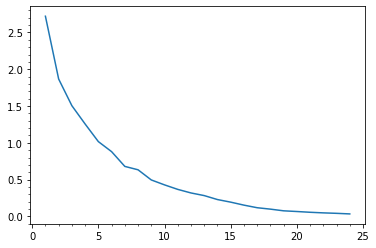

In [96]:
plt.plot(list(K),Sum_of_squared_distances)
plt.minorticks_on()

### Now let's look at the cluster

## Cluster 1

In [97]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bookstore,Hotel,Electronics Store,Bubble Tea Shop,Sushi Restaurant,Café,Breakfast Spot
1,Downtown Toronto,0,Coffee Shop,Gay Bar,Italian Restaurant,Japanese Restaurant,Pizza Place,Men's Store,Ice Cream Shop,Juice Bar,Liquor Store,Martial Arts School
2,Downtown Toronto,0,Coffee Shop,Sandwich Place,Italian Restaurant,Salad Place,Department Store,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Thai Restaurant,Spa
3,Downtown Toronto,0,Coffee Shop,Hotel,Clothing Store,Café,Bar,Sushi Restaurant,Office,Seafood Restaurant,Salad Place,Cosmetics Shop
4,East Toronto,0,Park,Yoga Studio,Athletics & Sports,Sporting Goods Shop,French Restaurant,Juice Bar,Bar,Italian Restaurant,BBQ Joint,Salon / Barbershop
5,Downtown Toronto,0,Hotel,Coffee Shop,Café,Italian Restaurant,Restaurant,Aquarium,Theater,General Entertainment,Pub,Scenic Lookout
6,Downtown Toronto,0,Coffee Shop,Sandwich Place,Hotel,Middle Eastern Restaurant,Sushi Restaurant,Clothing Store,Plaza,Café,Bookstore,Restaurant
7,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Café,Japanese Restaurant,Burger Joint,Hotel,Italian Restaurant,Restaurant,Pizza Place,Salad Place
8,Downtown Toronto,0,Coffee Shop,Café,Steakhouse,Thai Restaurant,Bar,Gym,Sushi Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant
9,West Toronto,0,Coffee Shop,Gay Bar,Café,Japanese Restaurant,Sushi Restaurant,Yoga Studio,Restaurant,Bubble Tea Shop,Mediterranean Restaurant,Martial Arts School


#### In the first cluster we see a lot of Coffee Shop as the 1st most common venue

## Cluster 2

In [98]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Central Toronto,1,Dog Run,Park,Breakfast Spot,Beer Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room
23,Central Toronto,1,Dog Run,Park,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Distribution Center


#### In the second cluster we have Dog Run as the most common venye

In [99]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,East Toronto,2,Park,Gym / Fitness Center,Neighborhood_cat,Metro Station,Athletics & Sports,Yoga Studio,Distribution Center,Event Space,Ethiopian Restaurant,Escape Room
31,Central Toronto,2,Park,Gym / Fitness Center,Neighborhood_cat,Yoga Studio,Distribution Center,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store


#### In the 3rd cluster we have Park as the 1st most common venue

In [100]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,3,Swim School,Coffee Shop,Bus Line,Distribution Center,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store


#### In the fourth cluster we see swim school as the 1st most common

In [101]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,4,Breakfast Spot,Park,Beer Store,Japanese Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room


#### Finally in the fifth cluster Breakfast Spot is the most common venue